In [55]:
"""Imports"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from pathlib import Path
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchmetrics.classification import MulticlassConfusionMatrix
from torchvision import transforms
from torchvision.io import decode_image

import optuna

In [56]:
"""Set seeds and device"""
np.random.seed(73)
torch.manual_seed(73)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(73)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Prepare data for CNN architecture

In [57]:
"""Custom classes for loading data through dataloader as adapted from https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html"""
class SpectrogramDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = Path(self.img_dir, self.img_labels.iloc[idx, 1])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [71]:
"""Early Stopper class to stop training when validation loss does not improve"""

class EarlyStopper:
    def __init__(self, patience=25, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [59]:
"""Load data using custom class defined above and split into train/validate/test datasets"""
DATA_PATH = Path(Path.cwd().parent, "Data")

data_transformers=transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor()])

leaf_dataset = SpectrogramDataset(annotations_file=Path(DATA_PATH, "Spectrogram", "all.csv"), img_dir=Path(DATA_PATH, "Spectrogram"), transform=data_transformers)
train_dataset, valid_dataset, test_dataset = random_split(leaf_dataset, [0.6, 0.2, 0.2])

train_dataset

In [60]:
"""Convert those datasets into batch loaders"""
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

train_loader

Build Model

In [61]:
"""Combined CNN-LSTM architecture as adapted from https://www.mathworks.com/help/deeplearning/ug/sequence-classification-using-cnn-lstm-network.html"""
class ComposerCNN(nn.Module):
    def __init__(self, input_size, filter_size, num_filters, num_hidden_units, num_classes):
        super(ComposerCNN, self).__init__()
        self.convolve = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),

            nn.Conv2d(in_channels=num_filters, out_channels=2*num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),

            nn.Conv2d(in_channels=2*num_filters, out_channels=2*num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),

            nn.Flatten(),
        )        

        self.fc = nn.Linear(3072, num_classes) 

    def forward(self, x):
        x = self.convolve(x)
        x = self.fc(x)
        return x

Train Model

In [62]:
"""Define training loop for CNN-LSTM model"""

def train(model, training, validation, lr=0.001):

	criterion = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	
	train_losses = []
	model.train()
	for inputs, labels in training:
		inputs, labels = inputs.to(device), labels.to(device)
		optimizer.zero_grad()
		output = model(inputs)
		loss = criterion(output, labels)
		loss.backward()
		optimizer.step()
		train_losses.append(loss.item())
		
	validation_losses = []
	model.eval()
	with torch.no_grad():
		for v_inputs, v_labels in validation:
			v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
			v_output = model(v_inputs)
			validation_loss = criterion(v_output, v_labels)	
			validation_losses.append(validation_loss.item())
	return train_losses, validation_losses

# Train CNN model

EarlyStopper = EarlyStopper(patience=25, delta=1e-4)

epochs = 300
model = ComposerCNN(input_size=1, filter_size=3, num_filters=64, num_hidden_units=256, num_classes=4).to(device)

total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
	epoch_train_loss, epoch_validation_loss = train(model, train_loader, valid_loader)
	total_train_losses.extend(epoch_train_loss)
	total_validation_losses.extend(epoch_validation_loss)
	if (epoch + 1) % 10 == 0:
		print(f"Epoch {epoch + 1}, train loss: {epoch_train_loss[-1]:.4f}, validation loss: {epoch_validation_loss[-1]:.4f}")

	EarlyStopper(epoch_validation_loss[-1])
	if EarlyStopper.early_stop:
		print("Early stopping triggered")
		break

Epoch 10, train loss: 0.0487, validation loss: 0.9132
Epoch 20, train loss: 0.0151, validation loss: 0.4261
Epoch 30, train loss: 0.0000, validation loss: 0.0001
Early stopping triggered


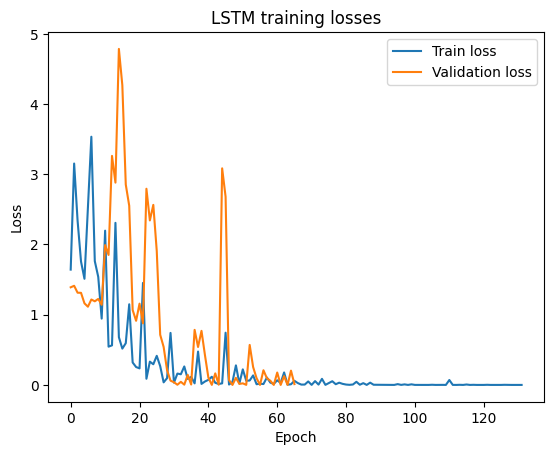

In [63]:
"""Plot training and Validation losses"""
plt.title("LSTM training losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses, label="Train loss")
plt.plot(total_validation_losses, label="Validation loss")
plt.legend()
plt.show()

Evaluate Model

In [64]:
"""Create tensors to use in performance metric creation"""
prediction = torch.Tensor().to(device)
truth = torch.Tensor().to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        prediction = torch.cat([prediction, predicted], dim=0)
        truth = torch.cat([truth, labels], dim=0)
        
assert prediction.shape == truth.shape
print(prediction.shape)

torch.Size([80])


In [65]:
"""Create performance metrics"""
accuracy = Accuracy(task="multiclass", num_classes=32).to(device)
precision = Precision(task="multiclass", average="macro", num_classes=32).to(device)
recall = Recall(task="multiclass", average="macro", num_classes=32).to(device)
f1_score = F1Score(task="multiclass", average="macro", num_classes=32).to(device)
confusion_matric = ConfusionMatrix(task="multiclass", num_classes=32).to(device)

calculated_accuracy = accuracy(truth, prediction)
calculated_precision = precision(truth, prediction)
calculated_recall = recall(truth, prediction)
calculated_f1_score = f1_score(truth, prediction)
calculated_confusion_matric = confusion_matric(truth, prediction)

print("Model Accuracy:", calculated_accuracy)
print("Model Precision:", calculated_precision)
print("Model Recall:", calculated_recall)
print("Model F1:", calculated_f1_score)

Model Accuracy: tensor(0.9000, device='cuda:0')
Model Precision: tensor(0.9088, device='cuda:0')
Model Recall: tensor(0.9109, device='cuda:0')
Model F1: tensor(0.9040, device='cuda:0')


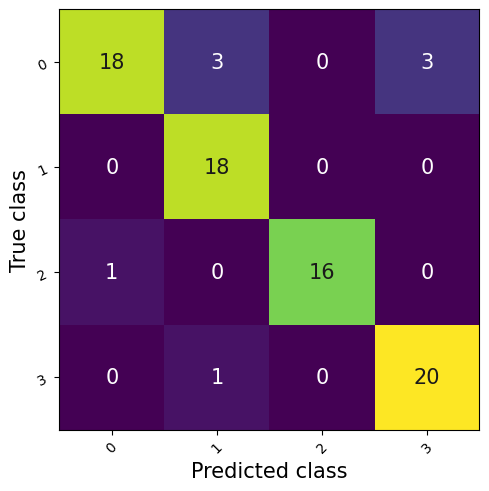

In [66]:
"""Vizulaize confusion matrix"""
metric = MulticlassConfusionMatrix(num_classes=4).to(device)
metric.update(truth, prediction)
fig_, ax_ = metric.plot()

Optimize hyperparameters

In [85]:
"""Use Optuna to optimize hyperparameters"""

class ComposerCNNOptimized(nn.Module):
    def __init__(self, input_size, filter_size, num_filters, num_hidden_units, num_classes, dropout_rate=0.5):
        super(ComposerCNNOptimized, self).__init__()
        self.convolve = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),
            
            nn.Conv2d(in_channels=num_filters, out_channels=2*num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),
            
            nn.Conv2d(in_channels=2*num_filters, out_channels=2*num_filters, kernel_size=filter_size, padding="same"),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2)),
            
            nn.Flatten(),
        )

        self.dropout = nn.Dropout(dropout_rate)

        input = torch.zeros(1, input_size, 128, 385)
        with torch.no_grad():
            output = self.convolve(input)
            flattened_size = output.view(1, -1).size(1)

        self.fc = nn.Linear(flattened_size, num_classes)
        

    def forward(self, x):
        x = self.convolve(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


def objective(trial):
    filter_size = trial.suggest_int("filter_size", 2, 5)
    num_filters = trial.suggest_int("num_filters", 32, 128)
    num_hidden_units = trial.suggest_int("num_hidden_units", 64, 512)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    model = ComposerCNNOptimized(input_size=1, filter_size=filter_size, num_filters=num_filters, num_hidden_units=num_hidden_units, num_classes=4, dropout_rate=dropout_rate).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for v_inputs, v_labels in valid_loader:
            v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            v_outputs = model(v_inputs)
            loss = criterion(v_outputs, v_labels)
            _, predicted = torch.max(v_outputs.data, 1)
            total += v_labels.size(0)
            correct += (predicted == v_labels).sum().item()

    val_accuracy = correct / total
    return val_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)
    

[I 2025-08-01 19:59:45,476] A new study created in memory with name: no-name-4786ada2-7e3e-4b34-86f6-2c8bf6ba9d9f
[I 2025-08-01 20:02:35,581] Trial 0 finished with value: 0.9 and parameters: {'filter_size': 5, 'num_filters': 59, 'num_hidden_units': 89, 'lr': 0.0015927498916611133, 'dropout_rate': 0.28540543451308575}. Best is trial 0 with value: 0.9.
[I 2025-08-01 20:08:13,574] Trial 1 finished with value: 0.975 and parameters: {'filter_size': 5, 'num_filters': 93, 'num_hidden_units': 137, 'lr': 1.9757434176962707e-05, 'dropout_rate': 0.36076398140180355}. Best is trial 1 with value: 0.975.
[I 2025-08-01 20:08:44,805] Trial 2 finished with value: 0.975 and parameters: {'filter_size': 2, 'num_filters': 53, 'num_hidden_units': 86, 'lr': 0.004659825667215171, 'dropout_rate': 0.48097741433536145}. Best is trial 1 with value: 0.975.
[I 2025-08-01 20:09:06,087] Trial 3 finished with value: 0.9625 and parameters: {'filter_size': 3, 'num_filters': 42, 'num_hidden_units': 302, 'lr': 0.002971656

Best hyperparameters: {'filter_size': 5, 'num_filters': 100, 'num_hidden_units': 439, 'lr': 0.00027393993655748224, 'dropout_rate': 0.34242605802442294}
Best validation loss: 1.0


In [86]:
"""Train model using best hyperparameters"""

best_params = study.best_params
model = ComposerCNNOptimized(input_size=1, filter_size=best_params["filter_size"], num_filters=best_params["num_filters"], num_hidden_units=best_params["num_hidden_units"], num_classes=4, dropout_rate=best_params["dropout_rate"])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
criterion = nn.CrossEntropyLoss()

total_train_losses_opt = []
total_validation_losses_opt = []

earlystopper_opt = EarlyStopper(patience=25, delta=1e-4) 

epochs = 300
for epoch in range(epochs):
    epoch_train_loss, epoch_validation_loss = train(model, train_loader, valid_loader, lr=best_params["lr"])
    total_train_losses_opt.extend(epoch_train_loss)
    total_validation_losses_opt.extend(epoch_validation_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, train loss: {epoch_train_loss[-1]:.4f}, validation loss: {epoch_validation_loss[-1]:.4f}")   

    earlystopper_opt(epoch_validation_loss[-1])
    if earlystopper_opt.early_stop:
        print("Early stopping triggered")
        break



Epoch 10, train loss: 0.0277, validation loss: 0.6191
Epoch 20, train loss: 0.0013, validation loss: 0.0007
Epoch 30, train loss: 0.0031, validation loss: 0.0353
Early stopping triggered


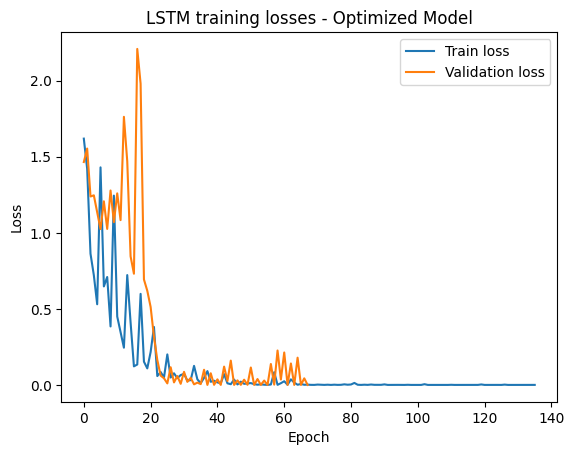

In [87]:
"""Plot training and Validation losses for the optimized model"""
plt.title("LSTM training losses - Optimized Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses_opt, label="Train loss")
plt.plot(total_validation_losses_opt, label="Validation loss")
plt.legend()
plt.show()

In [88]:
"""Create tensors to use in performance metric creation for the optimized model"""
prediction_opt = torch.Tensor()
truth_opt = torch.Tensor()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        prediction_opt = torch.cat([prediction, predicted], dim=0)
        truth_opt = torch.cat([truth, labels], dim=0)
        
assert prediction_opt.shape == truth_opt.shape
print(prediction_opt.shape)

torch.Size([82])


In [89]:
"""Create performance metrics for the optimized model"""
accuracy = Accuracy(task="multiclass", num_classes=32).to(device)
precision = Precision(task="multiclass", average="macro", num_classes=32).to(device)
recall = Recall(task="multiclass", average="macro", num_classes=32).to(device)
f1_score = F1Score(task="multiclass", average="macro", num_classes=32).to(device)
confusion_matric = ConfusionMatrix(task="multiclass", num_classes=32).to(device)

calculated_accuracy_opt = accuracy(truth_opt, prediction_opt)
calculated_precision_opt = precision(truth_opt, prediction_opt)
calculated_recall_opt = recall(truth_opt, prediction_opt)
calculated_f1_score_opt = f1_score(truth_opt, prediction_opt)
calculated_confusion_matric_opt = confusion_matric(truth_opt, prediction_opt)

print("Model Accuracy:", calculated_accuracy_opt)
print("Model Precision:", calculated_precision_opt)
print("Model Recall:", calculated_recall_opt)
print("Model F1:", calculated_f1_score_opt)

Model Accuracy: tensor(0.9024, device='cuda:0')
Model Precision: tensor(0.9114, device='cuda:0')
Model Recall: tensor(0.9119, device='cuda:0')
Model F1: tensor(0.9059, device='cuda:0')


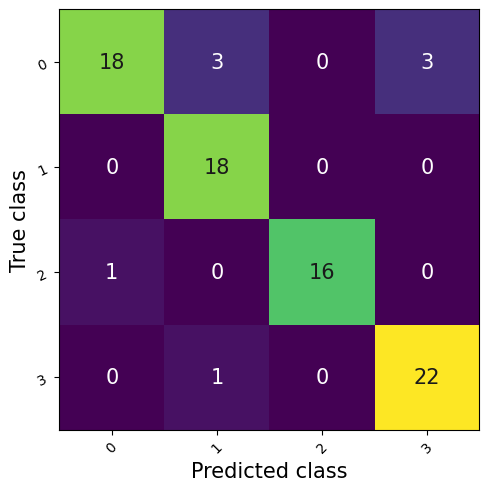

In [90]:
"""Vizulaize confusion matrix for oprtimized model"""
metric = MulticlassConfusionMatrix(num_classes=4).to(device)
metric.update(truth_opt, prediction_opt)
fig_, ax_ = metric.plot()

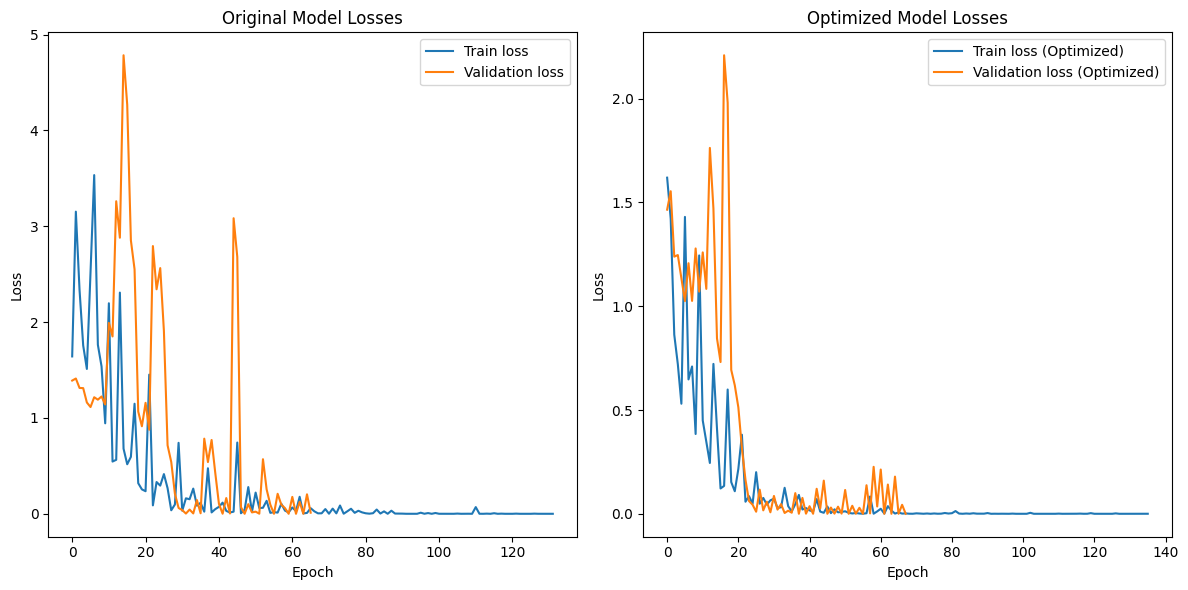

In [91]:
"""Side by side comparison of losses"""

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(total_train_losses, label="Train loss")
axs[0].plot(total_validation_losses, label="Validation loss")
axs[0].set_title("Original Model Losses")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(total_train_losses_opt, label="Train loss (Optimized)")
axs[1].plot(total_validation_losses_opt, label="Validation loss (Optimized)")
axs[1].set_title("Optimized Model Losses")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
"""Table of performance metrics for both models"""

performance_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Original Model": [calculated_accuracy.item(), calculated_precision.item(), calculated_recall.item(), calculated_f1_score.item()],
    "Optimized Model": [calculated_accuracy_opt.item(), calculated_precision_opt.item(), calculated_recall_opt.item(), calculated_f1_score_opt.item()]
})
performance_metrics.set_index("Metric", inplace=True)
print(performance_metrics)


           Original Model  Optimized Model
Metric                                    
Accuracy         0.900000         0.902439
Precision        0.908779         0.911388
Recall           0.910889         0.911925
F1 Score         0.903999         0.905893


Notes:

Added early stopping to the original model because the loss was converging rapidly to zero. (Model was memorizing data instead of learning.)

Used Optuna to perform hyperparameter tuning. Originally ran to minimize validation loss, but changed to maximize accuracy after results did not improve. 
Optuna produced the following best hyperparameters:
- Filter size: 5
- Number of filters: 100
- Hidden units: 439
- Learning rate: 0.00027394
- Dropout rate: 0.3424
These results were used to train the optimized model. 

The optimized model achieve a small improvement in accuracy, precision, recall, and FI score, but validation loss is slightly higher. (Model is performing better at getting the right answers, but may not perform as well on new data.)

